# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password12345")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\gipch\AppData\Local\Temp\ipykernel_9256\3806746930.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [12]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Affärsfråga: Hur många produkter finns i varje kategori?

Tabeller som använts:
Production.ProductCategory
Production.ProductSubCategory
Production.Product

Plan:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa ett vertikalt stapeldiagram
Analysera resultatet

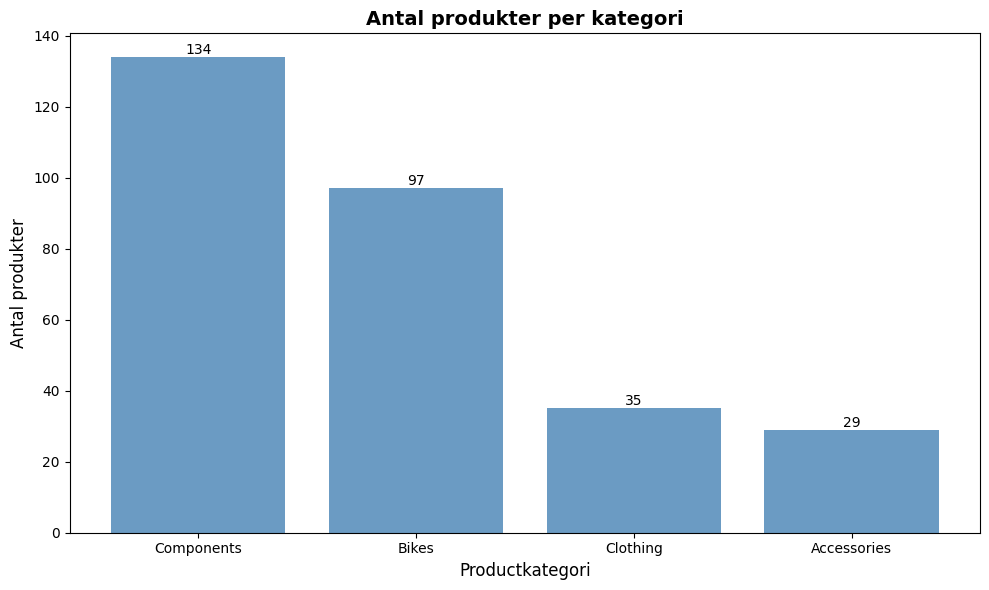

In [13]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)



fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )



ax.set_xlabel('Productkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Components är en största kategorin med 134 produkter.
Accessoarer är minst med 29 produkter.

Dettta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Och att accessoarerkan vara ett utvecklingsområde.

## Visualisering 2: Total försäljning per produktkategori
Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Tabeller som använts: 
Production.ProductCategory
Production.ProductSubcategory
Production.Product
Sales.SalesOrderDetail

Metod: 
Joina kategori → subkategori → produkt → orderrader Summera LineTotal per kategori.
Sortera högst till lägst försäljninng
Skapa ett horisontellt stapeldiagram
Beskriv vilken kategori som är störst/minst

In [14]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON sod.ProductID = p.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""
df_vis2 = query_df(query_vis2)
df_vis2.head()



,CategoryName,TotalSales
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


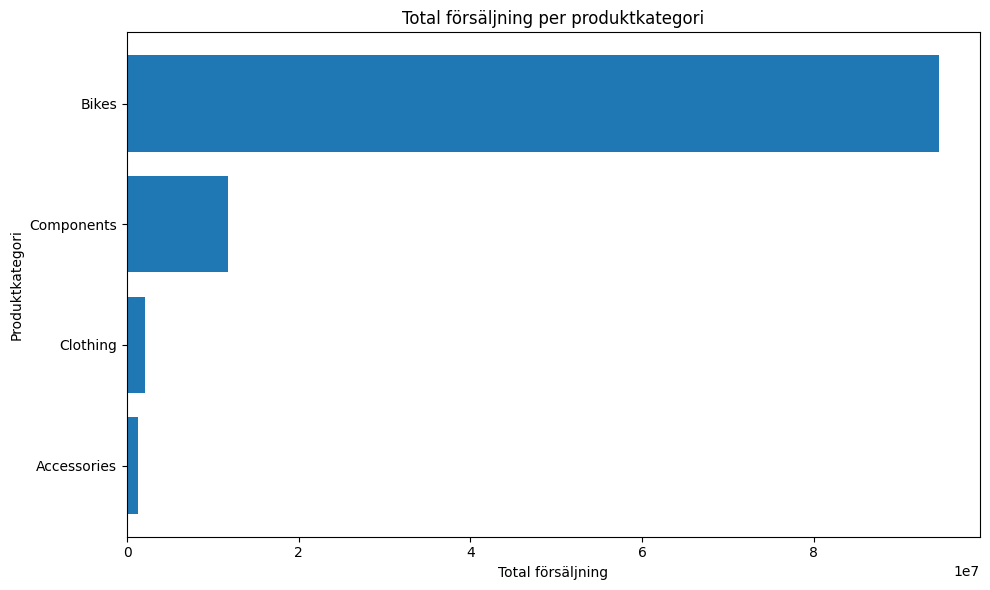

In [15]:
df_plot = df_vis2.sort_values("TotalSales", ascending=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(df_plot["CategoryName"], df_plot["TotalSales"])

ax.set_title("Total försäljning per produktkategori")
ax.set_xlabel("Total försäljning")
ax.set_ylabel("Produktkategori")

plt.tight_layout()
plt.show()



In [16]:
top = df_vis2.iloc[0]
bottom = df_vis2.iloc[-1]
top, bottom


(CategoryName              Bikes
 TotalSales      94651172.704731
 Name: 0, dtype: object,
 CategoryName       Accessories
 TotalSales      1272072.883926
 Name: 3, dtype: object)

### Insikter – Total försäljning per produktkategori

Störst kategori: Bikes med 94651172.704731 i total försäljning.

Minst kategori: Accessories med 1272072.883926 i total försäljning.

## Visualisering 3: Försäljningstrend per månad
Affärsfråga: Hur har försäljningen utvecklats över tid?

Tabeller som används:

Sales.SalesOrderHeader

Plan:

Hämta total försäljning per månad (SQL: GROUP BY månad)
Sortera kronologiskt (äldst först)
Visa minst 12 månader data
Skapa linjediagram
Hitta högsta och lägsta månad och beskriv trenden

In [17]:
query_vis3 = """
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS MonthStart,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY MonthStart;
"""
df_vis3 = query_df(query_vis3)
df_vis3.head()


,MonthStart,TotalSales
0,2022-05-01,5.177374e+05
1,2022-06-01,2.001279e+06
2,2022-07-01,1.668510e+06
3,2022-08-01,1.326138e+06
4,2022-09-01,2.836410e+06


In [18]:
df_vis3["MonthStart"] = pd.to_datetime(df_vis3["MonthStart"])

# minst 12 månader (tar senaste 12)
df_12 = df_vis3.tail(12).copy()
df_12


,MonthStart,TotalSales
26,2024-07-01,4.918580e+06
27,2024-08-01,3.325296e+06
28,2024-09-01,4.539829e+06
29,2024-10-01,4.820725e+06
30,2024-11-01,3.291238e+06
31,2024-12-01,4.082854e+06
32,2025-01-01,4.276428e+06
33,2025-02-01,3.565879e+06
34,2025-03-01,4.987902e+06
35,2025-04-01,5.222759e+06


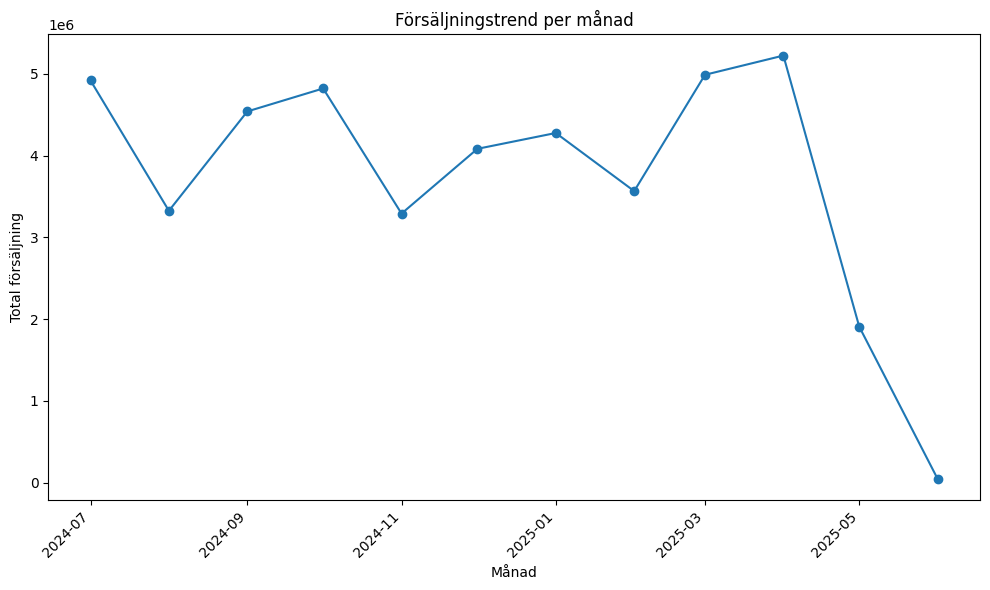

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_12["MonthStart"], df_12["TotalSales"], marker="o")

ax.set_title("Försäljningstrend per månad")
ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [20]:
max_row = df_12.loc[df_12["TotalSales"].idxmax()]
min_row = df_12.loc[df_12["TotalSales"].idxmin()]

print("Högsta månad:", max_row["MonthStart"].strftime("%Y-%m"), f"= {max_row['TotalSales']:,.0f}")
print("Lägsta månad:", min_row["MonthStart"].strftime("%Y-%m"), f"= {min_row['TotalSales']:,.0f}")


Högsta månad: 2025-04 = 5,222,759
Lägsta månad: 2025-06 = 47,492


### Insikter – Försäljningstrend per månad

Försäljningen varierar mellan månader, med en tydlig topp under våren.

Högsta månaden är 2025-04 med 5,222,759 i total försäljning.

Lägsta månaden är 2025-06 med 47,492 i total försäljning.

Den kraftiga nedgången i sista månaden kan tyda på att månaden är ofullständig (inte hela månaden finns med i datat), så trenden bör tolkas med försiktighet

## Visualisering 4: Försäljning och antal ordrar per år

Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:

Sales.SalesOrderHeader

Plan:

Gruppera data per år (YEAR(OrderDate))
Beräkna total försäljning (SUM(SubTotal))
Räkna antal ordrar (COUNT(SalesOrderID))
Sortera åren kronologiskt
Skapa grupperat stapeldiagram med två staplar per år
Jämför vilket år som har högst försäljning och om orderantal följer samma trend

In [21]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(SubTotal) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""
df_vis4 = query_df(query_vis4)
df_vis4


,OrderYear,TotalSales,OrderCount
0,2022,1.456105e+07,1692
1,2023,3.160492e+07,3830
2,2024,4.367189e+07,14244
3,2025,2.000852e+07,11699


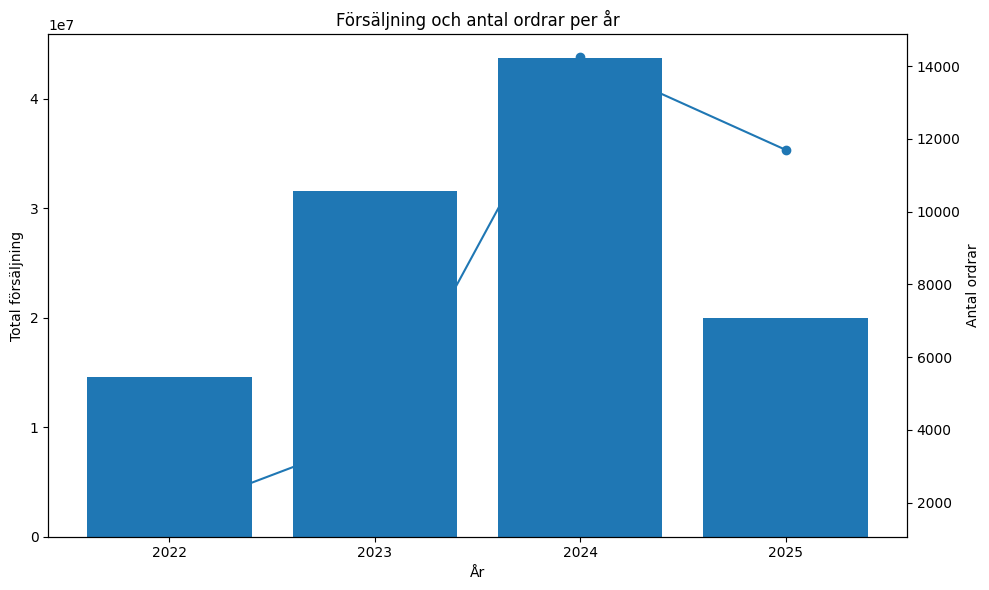

In [22]:
fig, ax1 = plt.subplots(figsize=(10,6))

x = df_vis4["OrderYear"].astype(str)
ax1.bar(x, df_vis4["TotalSales"])
ax1.set_title("Försäljning och antal ordrar per år")
ax1.set_xlabel("År")
ax1.set_ylabel("Total försäljning")

ax2 = ax1.twinx()
ax2.plot(x, df_vis4["OrderCount"], marker="o")
ax2.set_ylabel("Antal ordrar")

plt.tight_layout()
plt.show()


In [23]:
max_sales = df_vis4.loc[df_vis4["TotalSales"].idxmax()]
max_orders = df_vis4.loc[df_vis4["OrderCount"].idxmax()]

print("Högst försäljning:", int(max_sales["OrderYear"]), f"= {max_sales['TotalSales']:,.0f}")
print("Flest ordrar:", int(max_orders["OrderYear"]), f"= {max_orders['OrderCount']:,}")


Högst försäljning: 2024 = 43,671,890
Flest ordrar: 2024 = 14,244.0


### Insikter – Försäljning och antal ordrar per år

Året med högst försäljning är 2024 med 43,671,890 i total försäljning.

Året med flest ordrar är 2024 med 14,244.0 ordrar.

Både försäljning och antal ordrar ökar från 2022 till 2024, vilket tyder på stark tillväxt.
År 2025 är lägre än 2024, vilket kan bero på att året är ofullständigt i datat (inte hela året finns med).

Om försäljningen ökar mer än orderantalet kan det tyda på högre genomsnittligt ordervärde.

## Visualisering 5: Top 10 produkter efter försäljning
Affärsfråga: Vilka 10 produkter genererar mest försäljning?

Tabeller som används:

Production.Product

Sales.SalesOrderDetail

Plan:

Joina orderrader med produkter
Summera LineTotal per produkt
Sortera från högst till lägst och välj TOP 10
Skapa horisontellt stapeldiagram
Nämn #1 produkten med exakt försäljningsvärde och se vilken kategori som dominerar topp 10

In [27]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""
df_vis5 = query_df(query_vis5)
df_vis5


,ProductName,TotalSales
0,"Mountain-200 Black, 38",4.400593e+06
1,"Mountain-200 Black, 42",4.009495e+06
2,"Mountain-200 Silver, 38",3.693678e+06
3,"Mountain-200 Silver, 42",3.438479e+06
4,"Mountain-200 Silver, 46",3.434257e+06
5,"Mountain-200 Black, 46",3.309673e+06
6,"Road-250 Black, 44",2.516857e+06
7,"Road-250 Black, 48",2.347656e+06
8,"Road-250 Black, 52",2.012448e+06
9,"Road-150 Red, 56",1.847819e+06


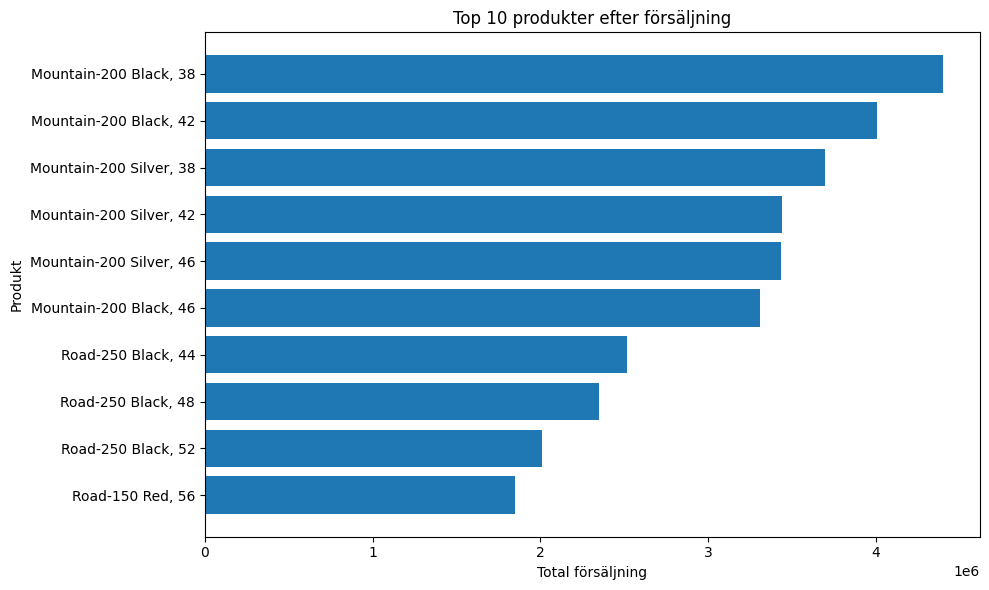

In [28]:
df_plot = df_vis5.sort_values("TotalSales", ascending=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(df_plot["ProductName"], df_plot["TotalSales"])

ax.set_title("Top 10 produkter efter försäljning")
ax.set_xlabel("Total försäljning")
ax.set_ylabel("Produkt")

plt.tight_layout()
plt.show()


In [29]:
top1 = df_vis5.iloc[0]
print("1:a produkt:", top1["ProductName"], f"= {top1['TotalSales']:,.0f}")


1:a produkt: Mountain-200 Black, 38 = 4,400,593


In [30]:
query_vis5_cat = """
SELECT TOP 10
    p.Name AS ProductName,
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY TotalSales DESC;
"""
df_vis5_cat = query_df(query_vis5_cat)
df_vis5_cat


,ProductName,CategoryName,TotalSales
0,"Mountain-200 Black, 38",Bikes,4.400593e+06
1,"Mountain-200 Black, 42",Bikes,4.009495e+06
2,"Mountain-200 Silver, 38",Bikes,3.693678e+06
3,"Mountain-200 Silver, 42",Bikes,3.438479e+06
4,"Mountain-200 Silver, 46",Bikes,3.434257e+06
5,"Mountain-200 Black, 46",Bikes,3.309673e+06
6,"Road-250 Black, 44",Bikes,2.516857e+06
7,"Road-250 Black, 48",Bikes,2.347656e+06
8,"Road-250 Black, 52",Bikes,2.012448e+06
9,"Road-150 Red, 56",Bikes,1.847819e+06


In [31]:
df_vis5_cat["CategoryName"].value_counts()


CategoryName
Bikes    10
Name: count, dtype: int64

### Insikter: Top 10 produkter efter försäljning

#1 produkten är Mountain-200 Black, 38 med 4,400,593 i total försäljning.
Top 10 domineras helt av kategorin Bikes (10 av 10 produkter), vilket tyder på att cyklar står för de största intäkterna bland topprodukterna.

## Visualisering 6: Försäljning och antal kunder per region
Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:

Sales.SalesTerritory
Sales.SalesOrderHeader
Sales.Customer

Plan:

Joina orderheader med territory och customer
Summera försäljning per region
Räkna unika kunder per region (DISTINCT CustomerID)
Sortera regioner från högst till lägst försäljning
Skapa grupperat stapeldiagram med två staplar per region
Jämför starkaste/svagaste region och om högst försäljning också betyder flest kunder

In [32]:
query_vis6 = """
SELECT
    st.Name AS RegionName,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""
df_vis6 = query_df(query_vis6)
df_vis6


,RegionName,TotalSales,UniqueCustomers
0,Southwest,2.418461e+07,4565
1,Canada,1.635577e+07,1677
2,Northwest,1.608494e+07,3428
3,Australia,1.065534e+07,3625
4,Central,7.909009e+06,69
5,Southeast,7.879655e+06,91
6,United Kingdom,7.670721e+06,1951
7,France,7.251556e+06,1844
8,Northeast,6.939374e+06,57
9,Germany,4.915408e+06,1812


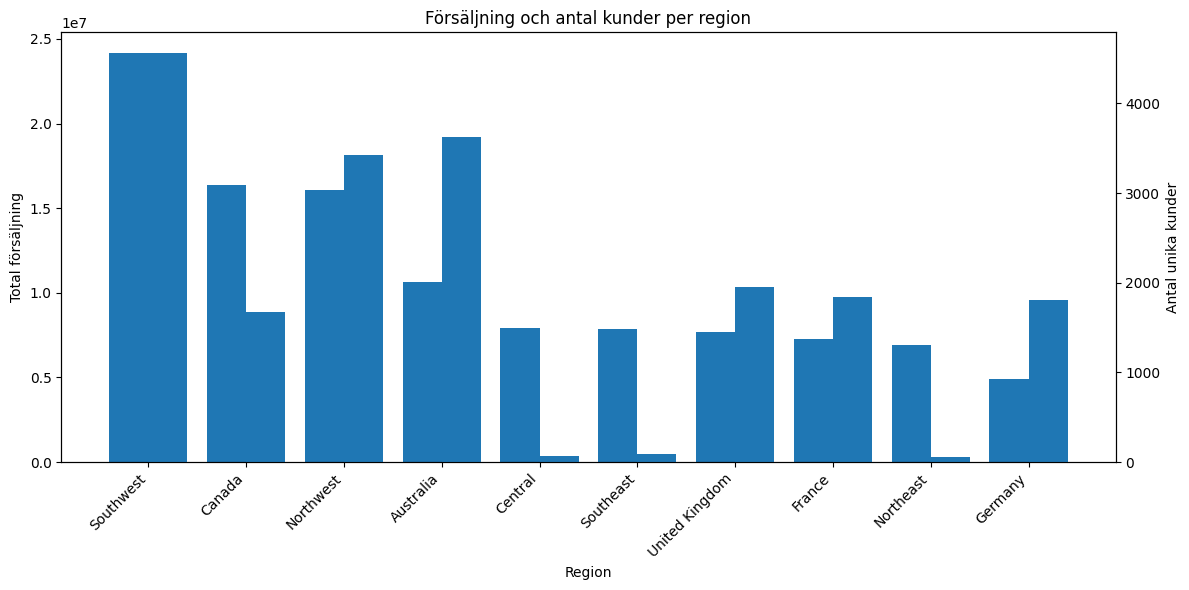

In [33]:
fig, ax1 = plt.subplots(figsize=(12,6))

x = df_vis6["RegionName"]
pos = range(len(x))
width = 0.4

# Stapel 1: försäljning (vänster y-axel)
ax1.bar([p - width/2 for p in pos], df_vis6["TotalSales"], width=width, label="Försäljning")
ax1.set_ylabel("Total försäljning")
ax1.set_xlabel("Region")
ax1.set_title("Försäljning och antal kunder per region")
ax1.set_xticks(list(pos))
ax1.set_xticklabels(x, rotation=45, ha="right")

# Stapel 2: kunder (höger y-axel)
ax2 = ax1.twinx()
ax2.bar([p + width/2 for p in pos], df_vis6["UniqueCustomers"], width=width, label="Antal kunder")
ax2.set_ylabel("Antal unika kunder")

plt.tight_layout()
plt.show()


In [35]:
top_region = df_vis6.iloc[0]
bottom_region = df_vis6.iloc[-1]

print("Starkast region:", top_region["RegionName"], f"= {top_region['TotalSales']:,.0f} försäljning, {top_region['UniqueCustomers']:,} kunder")
print("Svagast region:", bottom_region["RegionName"], f"= {bottom_region['TotalSales']:,.0f} försäljning, {bottom_region['UniqueCustomers']:,} kunder")


most_customers = df_vis6.loc[df_vis6["UniqueCustomers"].idxmax()]
print("Flest kunder:", most_customers["RegionName"], f"= {most_customers['UniqueCustomers']:,} kunder")


Starkast region: Southwest = 24,184,610 försäljning, 4,565 kunder
Svagast region: Germany = 4,915,408 försäljning, 1,812 kunder
Flest kunder: Southwest = 4,565 kunder


### Insikter – Försäljning och antal kunder per region

Den starkaste regionen är Southwest med 24 184 610 i total försäljning och 4 565 kunder.
Den svagaste regionen är Germany med 4 915 408 i total försäljning och 1 812 kunder.

Regionen med högst försäljning (Southwest) har också flest kunder, vilket tyder på att den höga försäljningen främst drivs av en större kundbas (snarare än bara högre ordervärde per kund).

## Visualisering 7: Genomsnittligt ordervärde per region och kundtyp

Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

Tabeller som använts:

Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer, Sales.Store

Metod:

Joina orderheader → territory → customer → store  
Dela upp kundtyp: Store (företag) vs Individual (privatperson)  
Beräkna genomsnittligt ordervärde: TotalSales / OrderCount per region och kundtyp  
Sortera regioner efter högst genomsnitt (totalt)  
Visualisera med grupperat stapeldiagram (två staplar per region)


In [36]:
query_vis7 = """
SELECT
    st.Name AS RegionName,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(DISTINCT soh.SalesOrderID) AS OrderCount,
    SUM(soh.SubTotal) / NULLIF(COUNT(DISTINCT soh.SalesOrderID), 0) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
INNER JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s
    ON c.StoreID = s.BusinessEntityID
GROUP BY
    st.Name,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY AvgOrderValue DESC;
"""

df_vis7 = query_df(query_vis7)
df_vis7.head()


,RegionName,CustomerType,TotalSales,OrderCount,AvgOrderValue
0,Southwest,Store,1.846646e+07,751,24589.1595
1,France,Store,4.607538e+06,188,24508.1804
2,Northwest,Store,1.243508e+07,536,23199.7686
3,United Kingdom,Store,4.279009e+06,188,22760.6852
4,Central,Store,7.906008e+06,376,21026.6174


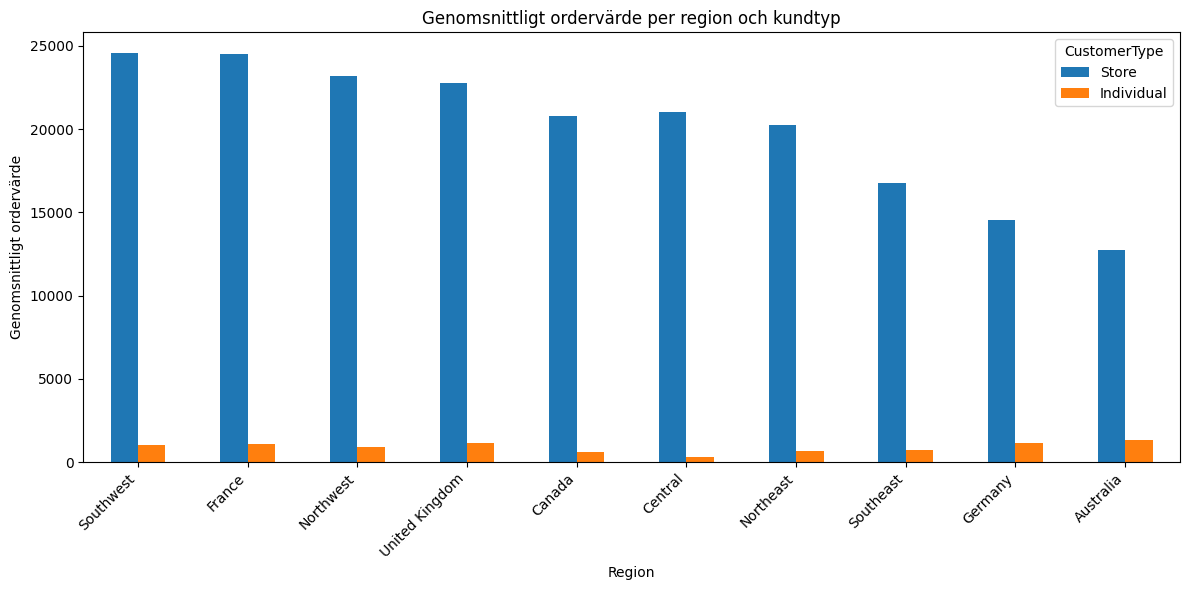

In [37]:
pivot_vis7 = df_vis7.pivot(index="RegionName", columns="CustomerType", values="AvgOrderValue").fillna(0)

pivot_vis7["TotalAvg"] = pivot_vis7.sum(axis=1)

pivot_vis7 = pivot_vis7.sort_values("TotalAvg", ascending=False)

plot_df = pivot_vis7[["Store", "Individual"]]

fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot(kind="bar", ax=ax)

ax.set_title("Genomsnittligt ordervärde per region och kundtyp")
ax.set_xlabel("Region")
ax.set_ylabel("Genomsnittligt ordervärde")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [38]:
top_region = pivot_vis7.index[0]
bottom_region = pivot_vis7.index[-1]
top_value = pivot_vis7.loc[top_region, "TotalAvg"]
bottom_value = pivot_vis7.loc[bottom_region, "TotalAvg"]

print("Högst totalt snitt:", top_region, f"= {top_value:,.0f}")
print("Lägst totalt snitt:", bottom_region, f"= {bottom_value:,.0f}")

best_combo = df_vis7.loc[df_vis7["AvgOrderValue"].idxmax()]
worst_combo = df_vis7.loc[df_vis7["AvgOrderValue"].idxmin()]

print("Högst kombination:", best_combo["RegionName"], best_combo["CustomerType"], f"= {best_combo['AvgOrderValue']:,.0f}")
print("Lägst kombination:", worst_combo["RegionName"], worst_combo["CustomerType"], f"= {worst_combo['AvgOrderValue']:,.0f}")


store_mean = plot_df["Store"].mean()
ind_mean = plot_df["Individual"].mean()

print("Snitt Store (över regioner):", f"{store_mean:,.0f}")
print("Snitt Individual (över regioner):", f"{ind_mean:,.0f}")


Högst totalt snitt: Southwest = 25,634
Lägst totalt snitt: Australia = 14,103
Högst kombination: Southwest Store = 24,589
Lägst kombination: Central Individual = 333
Snitt Store (över regioner): 20,120
Snitt Individual (över regioner): 893


### Insikter – Genomsnittligt ordervärde per region och kundtyp

Högst genomsnittligt ordervärde (totalt):** Southwest med 25 634 per order.  
Lägst genomsnittligt ordervärde (totalt): Australia med 14 103 per order.

Högsta region + kundtyp-kombination: Southwest Store med 24 589 per order.  
Lägsta region + kundtyp-kombination: Central Individual med 333 per order.

Store vs Individual: Företagskunder (Store) har i genomsnitt ett mycket högre ordervärde än privatkunder (Individual)  
  (20 120 vs 893 i snitt över regioner).  

Det här tyder på att B2B-kunder står för större ordrar, medan privatkunder oftare gör mindre köp. Skillnaderna mellan regioner kan bero på olika kundmix (hur stor andel företagskunder regionen har) och hur stora order kunderna tenderar att lägga.

